In [384]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tsfeatures import tsfeatures
from tsfeatures import acf_features

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 


from ts_tools.tools import tools
from data_loading_finance.loading_data import LoadingData


In [385]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")
df.head()

,Timestamp,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,USDCUSDT,XRPUSDT,DOGEUSDT,ADAUSDT,SHIBUSDT,AVAXUSDT
0,1/1/2021,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69
1,1/2/2021,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33
2,1/3/2021,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05
3,1/4/2021,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71
4,1/5/2021,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53


In [386]:
# Seleccionar las columnas deseadas del DataFrame original
df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'date', 'BTCUSDT': 'BTC'})
df_selected = df_selected.dropna()
print(df_selected)

           date       BTC
0      1/1/2021  29331.69
1      1/2/2021  32178.33
2      1/3/2021  33000.05
3      1/4/2021  31988.71
4      1/5/2021  33949.53
...         ...       ...
1240  5/25/2024  69290.57
1241  5/26/2024  68507.67
1242  5/27/2024  69436.43
1243  5/28/2024  68398.39
1244  5/29/2024  67652.42

[1245 rows x 2 columns]


In [387]:
df_selected["unique_id"]="1"
df_selected.columns=["ds", "y", "unique_id"]
df_selected.head()

,ds,y,unique_id
0,1/1/2021,29331.69,1
1,1/2/2021,32178.33,1
2,1/3/2021,33000.05,1
3,1/4/2021,31988.71,1
4,1/5/2021,33949.53,1


In [388]:
print(df_selected.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


**Apuntes**

En este apartado, hemos verificado rápidamente qué tipo de datos tiene cada columna, lo cual es crucial para asegurar que los datos se estén procesando correctamente y para elegir las operaciones adecuadas a realizar sobre ellos.

object: indica que es una columna de tipo objeto (generalmente significa que contiene cadenas de texto u otros tipos de datos no numéricos).
float64: indica que es una columna de números de punto flotante (números decimales).

In [389]:
df_selected["ds"] = pd.to_datetime(df_selected["ds"])
print(df_selected.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


**Apuntes**

En este apartado lo que he hecho es convertir la columna (tipo object) a serie temporal (datetime64[ns]).

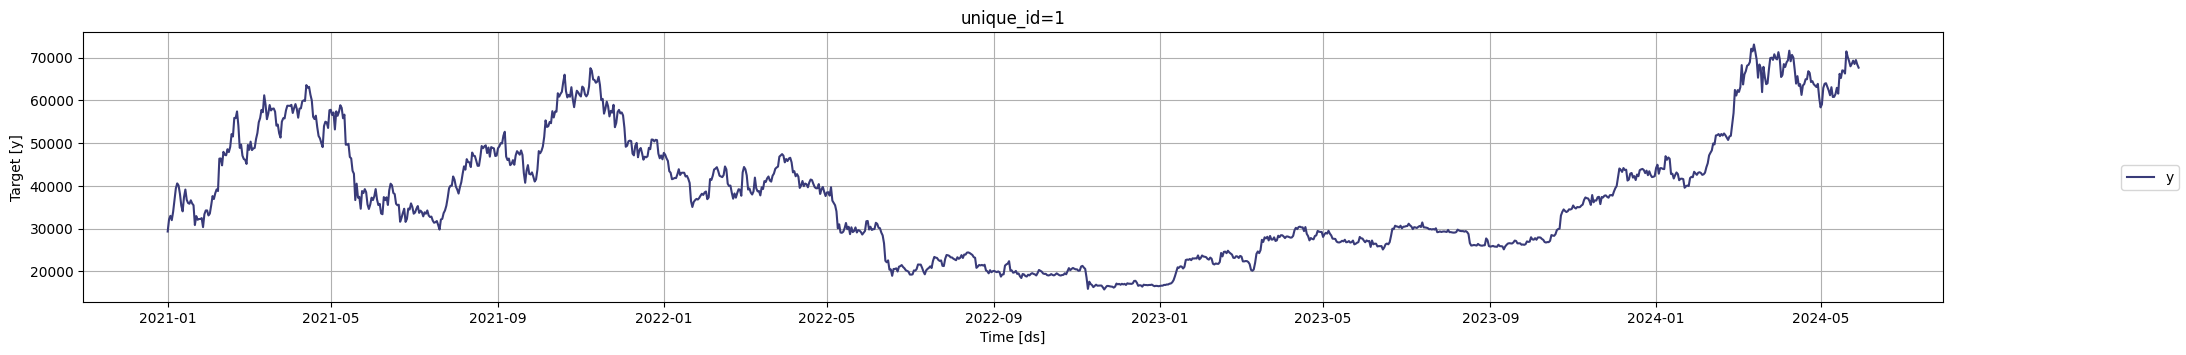

In [390]:
StatsForecast.plot(df_selected, engine="matplotlib")

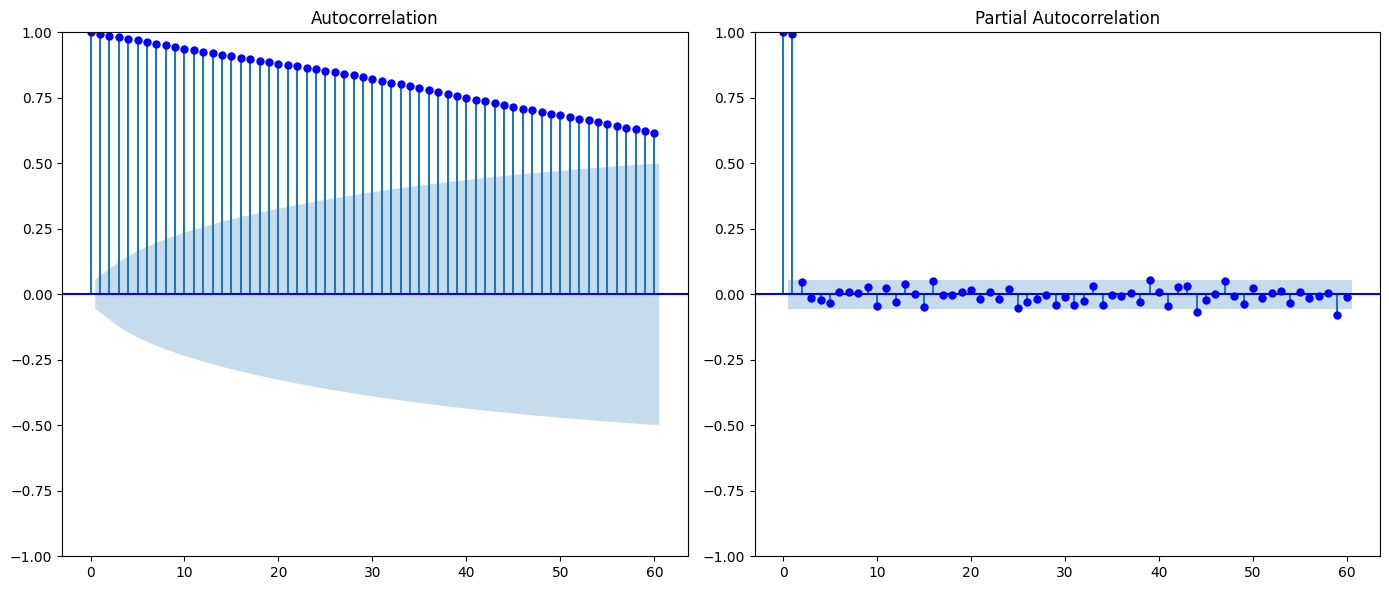

In [391]:
# Crear una figura con dos subgráficos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graficar ACF en el primer subgráfico
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelation")

# Graficar PACF en el segundo subgráfico
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Partial Autocorrelation')

# Ajustar el diseño para que no haya superposición de elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

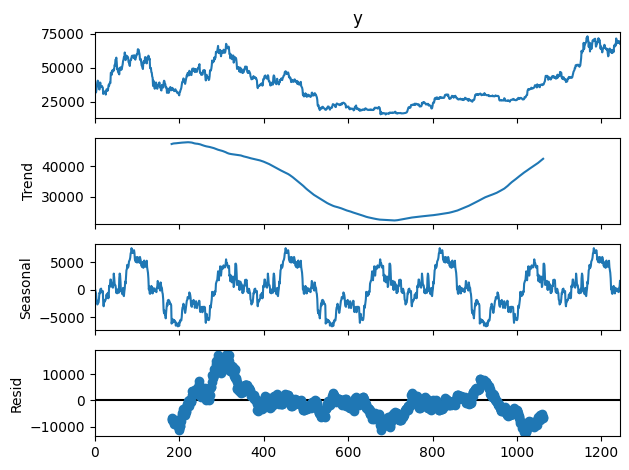

In [ ]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

In [393]:
Y_train_df = df_selected[df_selected.ds<='2024-05-01'] 
Y_test_df = df_selected[df_selected.ds>'2024-05-01']
Y_train_df.shape, Y_test_df.shape

((1217, 3), (28, 3))

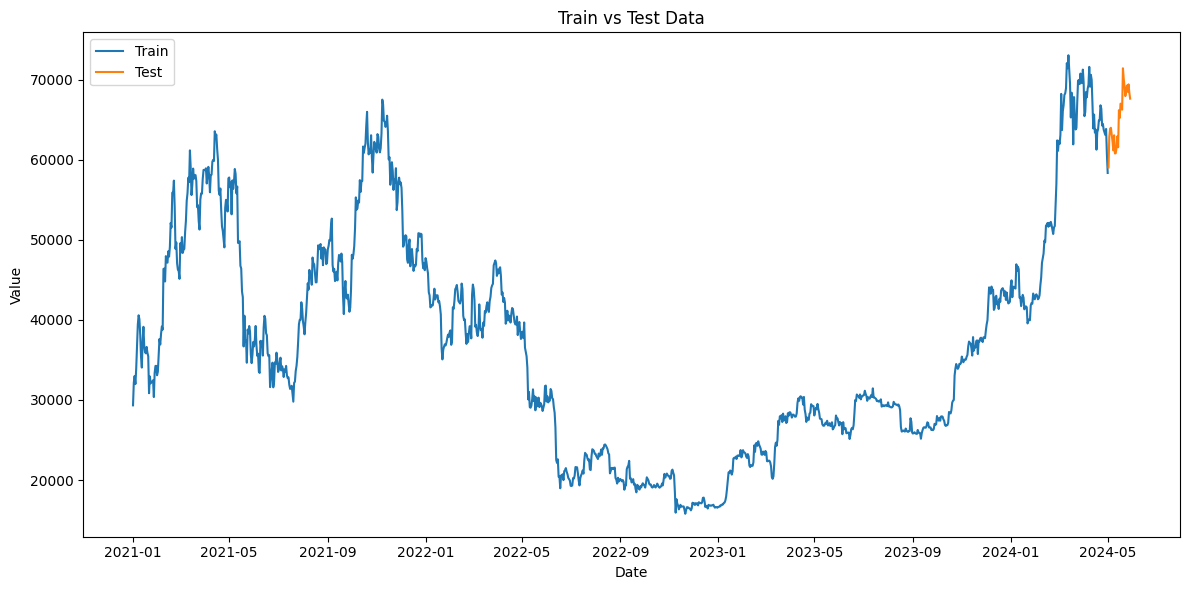

In [394]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las series temporales de entrenamiento y prueba
sns.lineplot(data=Y_train_df, x="ds", y="y", label="Train")
sns.lineplot(data=Y_test_df, x="ds", y="y", label="Test")

# Personalizar etiquetas y título
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train vs Test Data")
plt.legend()
plt.tight_layout()  
plt.show()


In [ ]:
season_length = 12 # Monthly data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In [396]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D', 
                   n_jobs=-1)